# Summary:
- This notebook will create some synthetic data (人造数据)
- Then use Keras Logistic Model to fit (linear model)
- Then use different model/tech to improve the results. (non-linear model)

> Note: for this script, use py35tf env(kernel) to run. (This is what I used when studying this lecture note)
- Maybe you can use py37tf_gpu to speed up the NN training, but some code may need to be upgraded if you change the env

In [2]:
import itertools

import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from scipy import signal

import cv2

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.datasets import mnist
import keras.backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


note: by default, Keras uses Tensorflow as Backend

In [5]:
import keras
keras.__version__

'2.2.2'

# 1. 神经网络

### 1.1 Synetic Data

In [6]:
#Generate the dataset using sklearn
X, t = make_circles(n_samples = 5000, shuffle=False, factor=0.3, noise=0.1)

#Separate the red and blue point (this is binary dataset, t is either 0 or 1)
x_red = X[t == 0]
x_blue = X[t == 1]

print('shape of X: {}'.format(X.shape))

shape of X: (5000, 2)


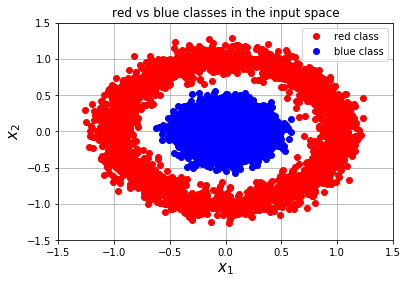

In [7]:
#Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='red class')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='blue class')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classes in the input space')
plt.show()

In [8]:
#Split dataset into trian and test
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.3, random_state = 0) #30% of total data as test set
                                                                                # random_state fixed to 0 -> let the output repeatable

### 1.2 Simple Logistic Regression (Linear Model)
<img src="./pic/simplelogisticregression.png">

> - single layer (only one input layer, no hidden layer)
- Dense network -> x1 and x2 both affect y (each path has its only parameter w1, w2)
- input dimension = 2 -> (x1, x2) -> x1 is horizontal coordinate; x2 is vertical coordinate (see picture above in 1.1)
- output: y corresponding to t=0 (red) or 1 (blue) as shown above in 1.1

In [18]:
#Build the simple logistic regression model
model = Sequential()
model.add(Dense(1, input_dim = 2, kernel_initializer = 'glorot_normal', activation = 'sigmoid'))
    #dense: dense network
    #1: dimension of output=1 -> output is either 1 or 0 scalar (here we only defined a single layer NN, so input is directly connected to final output layer)
    #input_dim=2: input dim = 2
    #"glorot_normal" as initializer
    #"sigmoid" function as activation function
sgd = SGD(lr=0.001, decay = 1e-6, momentum = 0.9, nesterov = True) #optimizer function
    #SGD here is not the simple SGD mentioned in the PDF, it includes the option to use "momentum" optimizer func/learning rate decay/Nesterov Accelerated Gradient optimizer func (refer to PDF lecture notes)
    #Lr= learning rate
    #decay=rate of decay (衰减率) of learning rate over each update.
    #momentum=0.9 -> resistance parameter (refer to PDF lecture notes)
    #nesterov=True -> use Nesterov Accelerated Gradient, to speed up training model (refer to PDF lecture notes)
    

model.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = 'adam')
#optimizer: we can also use sgd as defined above as optimizer, but here we can use 'adam' (see PDF lecture notes) since it is the most complete one
#loss: define loss function
#metrics: define metrics


history = model.fit(X_train, y_train, validation_data = (X_test, y_test),batch_size = 64, epochs = 10)

Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 0s 108us/step - loss: 0.7397 - acc: 0.4937 - val_loss: 0.7385 - val_acc: 0.5047
Epoch 2/10
3500/3500 [==============================] - 0s 12us/step - loss: 0.7350 - acc: 0.4917 - val_loss: 0.7342 - val_acc: 0.5027
Epoch 3/10
3500/3500 [==============================] - 0s 12us/step - loss: 0.7308 - acc: 0.4911 - val_loss: 0.7301 - val_acc: 0.5040
Epoch 4/10
3500/3500 [==============================] - 0s 12us/step - loss: 0.7269 - acc: 0.4883 - val_loss: 0.7265 - val_acc: 0.5013
Epoch 5/10
3500/3500 [==============================] - 0s 12us/step - loss: 0.7234 - acc: 0.4891 - val_loss: 0.7232 - val_acc: 0.5013
Epoch 6/10
3500/3500 [==============================] - 0s 13us/step - loss: 0.7202 - acc: 0.4900 - val_loss: 0.7201 - val_acc: 0.5000
Epoch 7/10
3500/3500 [==============================] - 0s 13us/step - loss: 0.7172 - acc: 0.4889 - val_loss: 0.7174 - val_acc: 0.5000
Epoch 

We can see from above, the model is not performed well, the accuracy is close to 50%, which means it is the same accuracy as if I just random guess the output (0 or 1)

> Reason: Logistic Regression is a linear model, it cannot solve non-linear problem in this example (see below visualization for better understanding)

#### Visualization of decision boundary

In [19]:
#Predition function by calling keras model predict method
#Will use 0.5 as threshold for binary classification
def nn_predict(model, X):
    
    return (model.predict(X) > 0.5).astype(int)

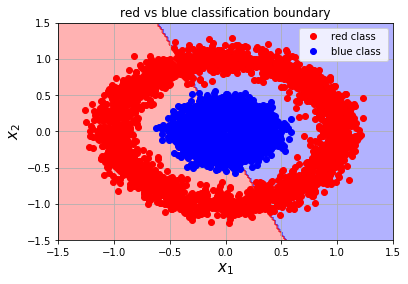

In [20]:
#Plot the resulting decision boundary
#Generate a grid over the input space to plot the color of the
#classification at that grid point
nb_of_xs = 200
xs1 = np.linspace(-2, 2, num = nb_of_xs)
xs2 = np.linspace(-2, 2, num = nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
#Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(model, np.array([[xx[i,j], yy[i,j]]]))
        classification_plane[i, j] = pred[0, 0]
#Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha = 0.30),
        colorConverter.to_rgba('r', alpha = 0.30)])

#Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
#Plot both classes on the x1, x2 plane
plt.plot(x_red[:, 0], x_red[:, 1], 'ro', label = 'red class')
plt.plot(x_blue[:, 0], x_blue[:, 1], 'bo', label = 'blue class ')
plt.grid()
plt.legend(loc = 1)
plt.xlabel('$x_1$', fontsize = 15)
plt.ylabel('$x_2$', fontsize = 15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classification boundary')
plt.show()

> Summary: we can see decision boundary is linear

#### Visualization of Confusion Matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
y_test_pred = nn_predict(model, X_test)
#Show confusion table
conf_matrix = confusion_matrix(y_test, y_test_pred, labels = None)

Confusion matrix, without normalization
[[361 360]
 [393 386]]


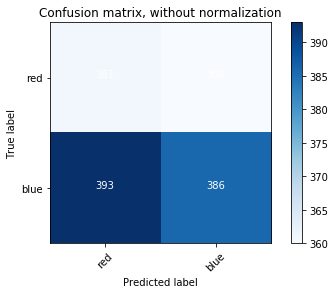

In [23]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['red', 'blue'],
                      title='Confusion matrix, without normalization')

> Summary: We can see confusion matrix prediction count is similar in each element of the matrix (Actual=red,Pred=red), (Actual=red, Pred=blue), (blue,red), (blue,blue), which means the separation/classification is not well.

### 1.3 Neural Network with Nonlinear Activation
In the previous section, we see that the logistic cannot correctly separate the two classes. The reason is that logistic regression is a linear model, which cannot separate nonlinear problem. From the classification boundary graph, we saw the separation bounday is a linear line. 

To correctly separate the two classes, we need add some nonlinear activation function and with more hidden layers. Keras offer lots of nonlinear functions: tanh, relu, sigmoid, softplus, etc. For more information, please see [Activation Functions in keras](https://keras.io/activations/).
> to make NN non-linear:
- use non-linear activation function
- add hidden layer

In this part, we will use a user-defined activation function, radial basis funciton(RBF). The RBF is a transfer function that is not usually used in neural networks, except for radial basis function networks. One of the most common transfer functions in neural networks is the sigmoid function. The RBF will allow to separate the blue samples from the red samples in this simple example by only activating for a certain region around the origin. The RBF is plotted in the figure below and is defined in this example as:

$$\text{RBF} = \phi(z) = e^{-z^2} $$

The derivative of this RBF function is:

$$\frac{d \phi(z)}{dz} = -2 z e^{-z^2} = -2 z \phi(z)$$

In [13]:
#Define the rbf function for visual purpose
def rbf_np(z):
    return np.exp(-z**2)

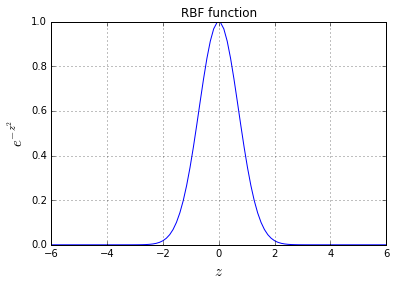

In [14]:
#Plot the rbf function
z = np.linspace(-6, 6, 100)
plt.plot(z, rbf_np(z), 'b-')
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$e^{-z^2}$', fontsize=15)
plt.title('RBF function')
plt.grid()
plt.show()

In [37]:
#Radius basis function for keras activation (Self-Defined)
def rbf(x):
    return K.exp(-1.0 * x ** 2) #keras.backend as K (see import section at the top)

<img src="./pic/NN_onehiddenlayer.png">

In [46]:
model = Sequential()
model.add(Dense(3, input_dim = 2, kernel_initializer = 'glorot_normal'))
#here: we add first layer of NN, input=original input (x1,x2), output of this layer is a 3-Dim hidden layer
model.add(Activation(rbf)) #here: we used the self-defined activation function between input layer and hidden layer

model.add(Dense(1, input_dim = 3, kernel_initializer = 'glorot_normal', activation = 'sigmoid'))
#here: we add second layer of NN, input=hidden layer(3-Dim), output=output y (0[red] or 1[blue]), 
    # with 'sigmoid' as activation function

#optimizer:
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

#compile model
model.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = sgd)

#fit model:
history = model.fit(X_train, y_train, verbose = 1, validation_data = (X_test, y_test), batch_size = 10, epochs = 10)
#note: It is quite common that the model results depending on choice of batch_size, activation function, optimizer, or other reasons that we cannot predict
# the only way is to try out each possibilities as possible.
# Here we tried out and find the batch_size = 10 performs way better than batch_size=64, that why it is 10 here
# Here we also tried out and find the optimizer of sgd performs way better than 'adam', that why we used it here

Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 1s 198us/step - loss: 0.5057 - acc: 0.8383 - val_loss: 0.3486 - val_acc: 0.9280
Epoch 2/10
3500/3500 [==============================] - 0s 81us/step - loss: 0.2746 - acc: 0.9751 - val_loss: 0.2190 - val_acc: 0.9967
Epoch 3/10
3500/3500 [==============================] - 0s 85us/step - loss: 0.1951 - acc: 0.9957 - val_loss: 0.1675 - val_acc: 0.9987
Epoch 4/10
3500/3500 [==============================] - 0s 88us/step - loss: 0.1555 - acc: 0.9963 - val_loss: 0.1375 - val_acc: 0.9993
Epoch 5/10
3500/3500 [==============================] - 0s 82us/step - loss: 0.1304 - acc: 0.9980 - val_loss: 0.1170 - val_acc: 0.9987
Epoch 6/10
3500/3500 [==============================] - 0s 81us/step - loss: 0.1129 - acc: 0.9989 - val_loss: 0.1026 - val_acc: 1.0000
Epoch 7/10
3500/3500 [==============================] - 0s 80us/step - loss: 0.1002 - acc: 0.9986 - val_loss: 0.0916 - val_acc: 1.0000
Epoch 

#### Visualization

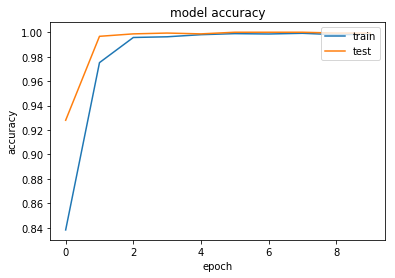

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

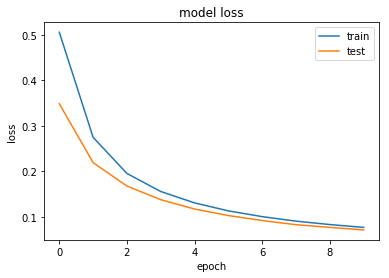

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

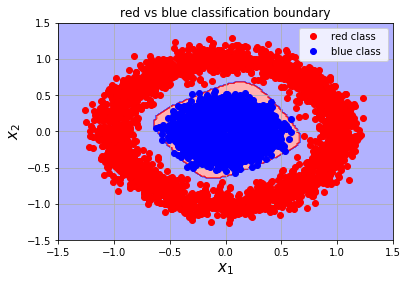

In [49]:
#Plot the resulting decision boundary
#Generate a grid over the input space to plot the color of the
#classification at that grid point
nb_of_xs = 200
xs1 = np.linspace(-2, 2, num = nb_of_xs)
xs2 = np.linspace(-2, 2, num = nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
#Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(model, np.array([[xx[i,j], yy[i,j]]]))
        classification_plane[i, j] = pred[0, 0]
#Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha = 0.30),
        colorConverter.to_rgba('r', alpha = 0.30)])

#Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap = cmap)
#Plot both classes on the x1, x2 plane
plt.plot(x_red[:, 0], x_red[:, 1], 'ro', label = 'red class')
plt.plot(x_blue[:, 0], x_blue[:, 1], 'bo', label = 'blue class ')
plt.grid()
plt.legend(loc = 1)
plt.xlabel('$x_1$', fontsize = 15)
plt.ylabel('$x_2$', fontsize = 15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classification boundary')
plt.show()

In [50]:
t_pred = nn_predict(model, X)
#Show confusion table
conf_matrix = confusion_matrix(t, t_pred, labels = None)

Confusion matrix, without normalization
[[2500    0]
 [   7 2493]]


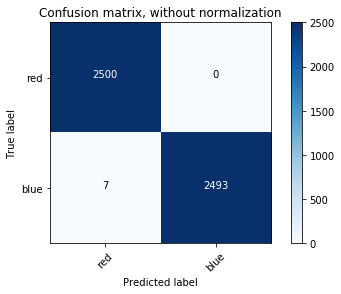

In [51]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['red', 'blue'],
                      title='Confusion matrix, without normalization')